In [5]:
import json
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Load the JSON file
with open('binary_multilabels.json', 'r') as file:
    data = json.load(file)

# Define the list of tags
tags = [
    "fish_tail", "shading", "short_descender", "string", "vertical_stretch",
    "nikud", "left_justify", "nesting", "left_slanted", "bited_aleph"
]

# Create a dictionary to store the tag vectors for each manuscript
manuscript_tags = {}

# Extract the images section which contains the tags
images = data['images']

# Initialize the tag vectors for each manuscript
for image in images:
    manuscript_name = image['image_name'].split('_')[0]
    if manuscript_name not in manuscript_tags:
        manuscript_tags[manuscript_name] = np.zeros(len(tags))
    
    # Set the corresponding tag positions to 1
    for tag in image['tags']:
        index = tags.index(tag)
        manuscript_tags[manuscript_name][index] = 1

# Convert to a list of vectors for further processing
manuscript_vectors = list(manuscript_tags.values())
manuscript_names = list(manuscript_tags.keys())


# Read the metadata file and extract dates and regions
metadata = {}
with open('mapping_sequentialnames_to_metadata_normaldate.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('" "')
        sequential_name = parts[0].strip('"')
        manuscript_name = sequential_name.split('_')[0]
        date = parts[3].strip('"')
        region = parts[4].strip('"')
        
        if manuscript_name not in metadata:
            metadata[manuscript_name] = {"date": date, "region": region}

# Get dates and regions for each manuscript
manuscript_dates = [metadata.get(name, {}).get("date", 'Unknown') for name in manuscript_names]
manuscript_regions = [metadata.get(name, {}).get("region", 'Unknown') for name in manuscript_names]







In [6]:
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mutual_info_score


# Compute Chi-Squared scores
chi_scores, p_values = chi2(manuscript_vectors, manuscript_regions)
# Select two features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=4)
chi2_selector.fit(manuscript_vectors, manuscript_regions)
# Look at scores returned from the selector for each feature
chi2_selector.scores_, chi2_selector.pvalues_



(array([0.88533884, 0.83889064, 0.53250751, 1.36401657, 1.27670614,
        0.24421646, 0.48725827, 2.570956  , 3.98857482, 0.78886555]),
 array([0.82896437, 0.84014405, 0.91169376, 0.71399069, 0.73467173,
        0.97015405, 0.92168166, 0.4626041 , 0.26270049, 0.85212835]))

In [7]:
chi2_selector.get_support()

array([False, False, False,  True,  True, False, False,  True,  True,
       False])

In [8]:
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mutual_info_score


# Filtering known samples
known_indices = [i for i, region in enumerate(manuscript_regions) if region in ['France', 'Germany']]
known_vectors = np.array([manuscript_vectors[i] for i in known_indices])
known_regions = [manuscript_regions[i] for i in known_indices]

# Compute Chi-Squared scores
chi_scores, p_values = chi2(known_vectors, known_regions)
# Select two features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=4)
chi2_selector.fit(known_vectors, known_regions)
# Look at scores returned from the selector for each feature
chi2_selector.scores_, chi2_selector.pvalues_



(array([0.47312131, 0.26737968, 0.11229947, 1.00142602, 1.00142602,
        0.02430724, 0.3426025 , 1.87165775, 1.8342246 , 0.64705882]),
 array([0.49155472, 0.60509495, 0.73754126, 0.3169657 , 0.3169657 ,
        0.87610569, 0.55833085, 0.17128534, 0.17562937, 0.42116619]))

In [9]:
chi2_selector.get_support()

array([False, False, False,  True,  True, False, False,  True,  True,
       False])

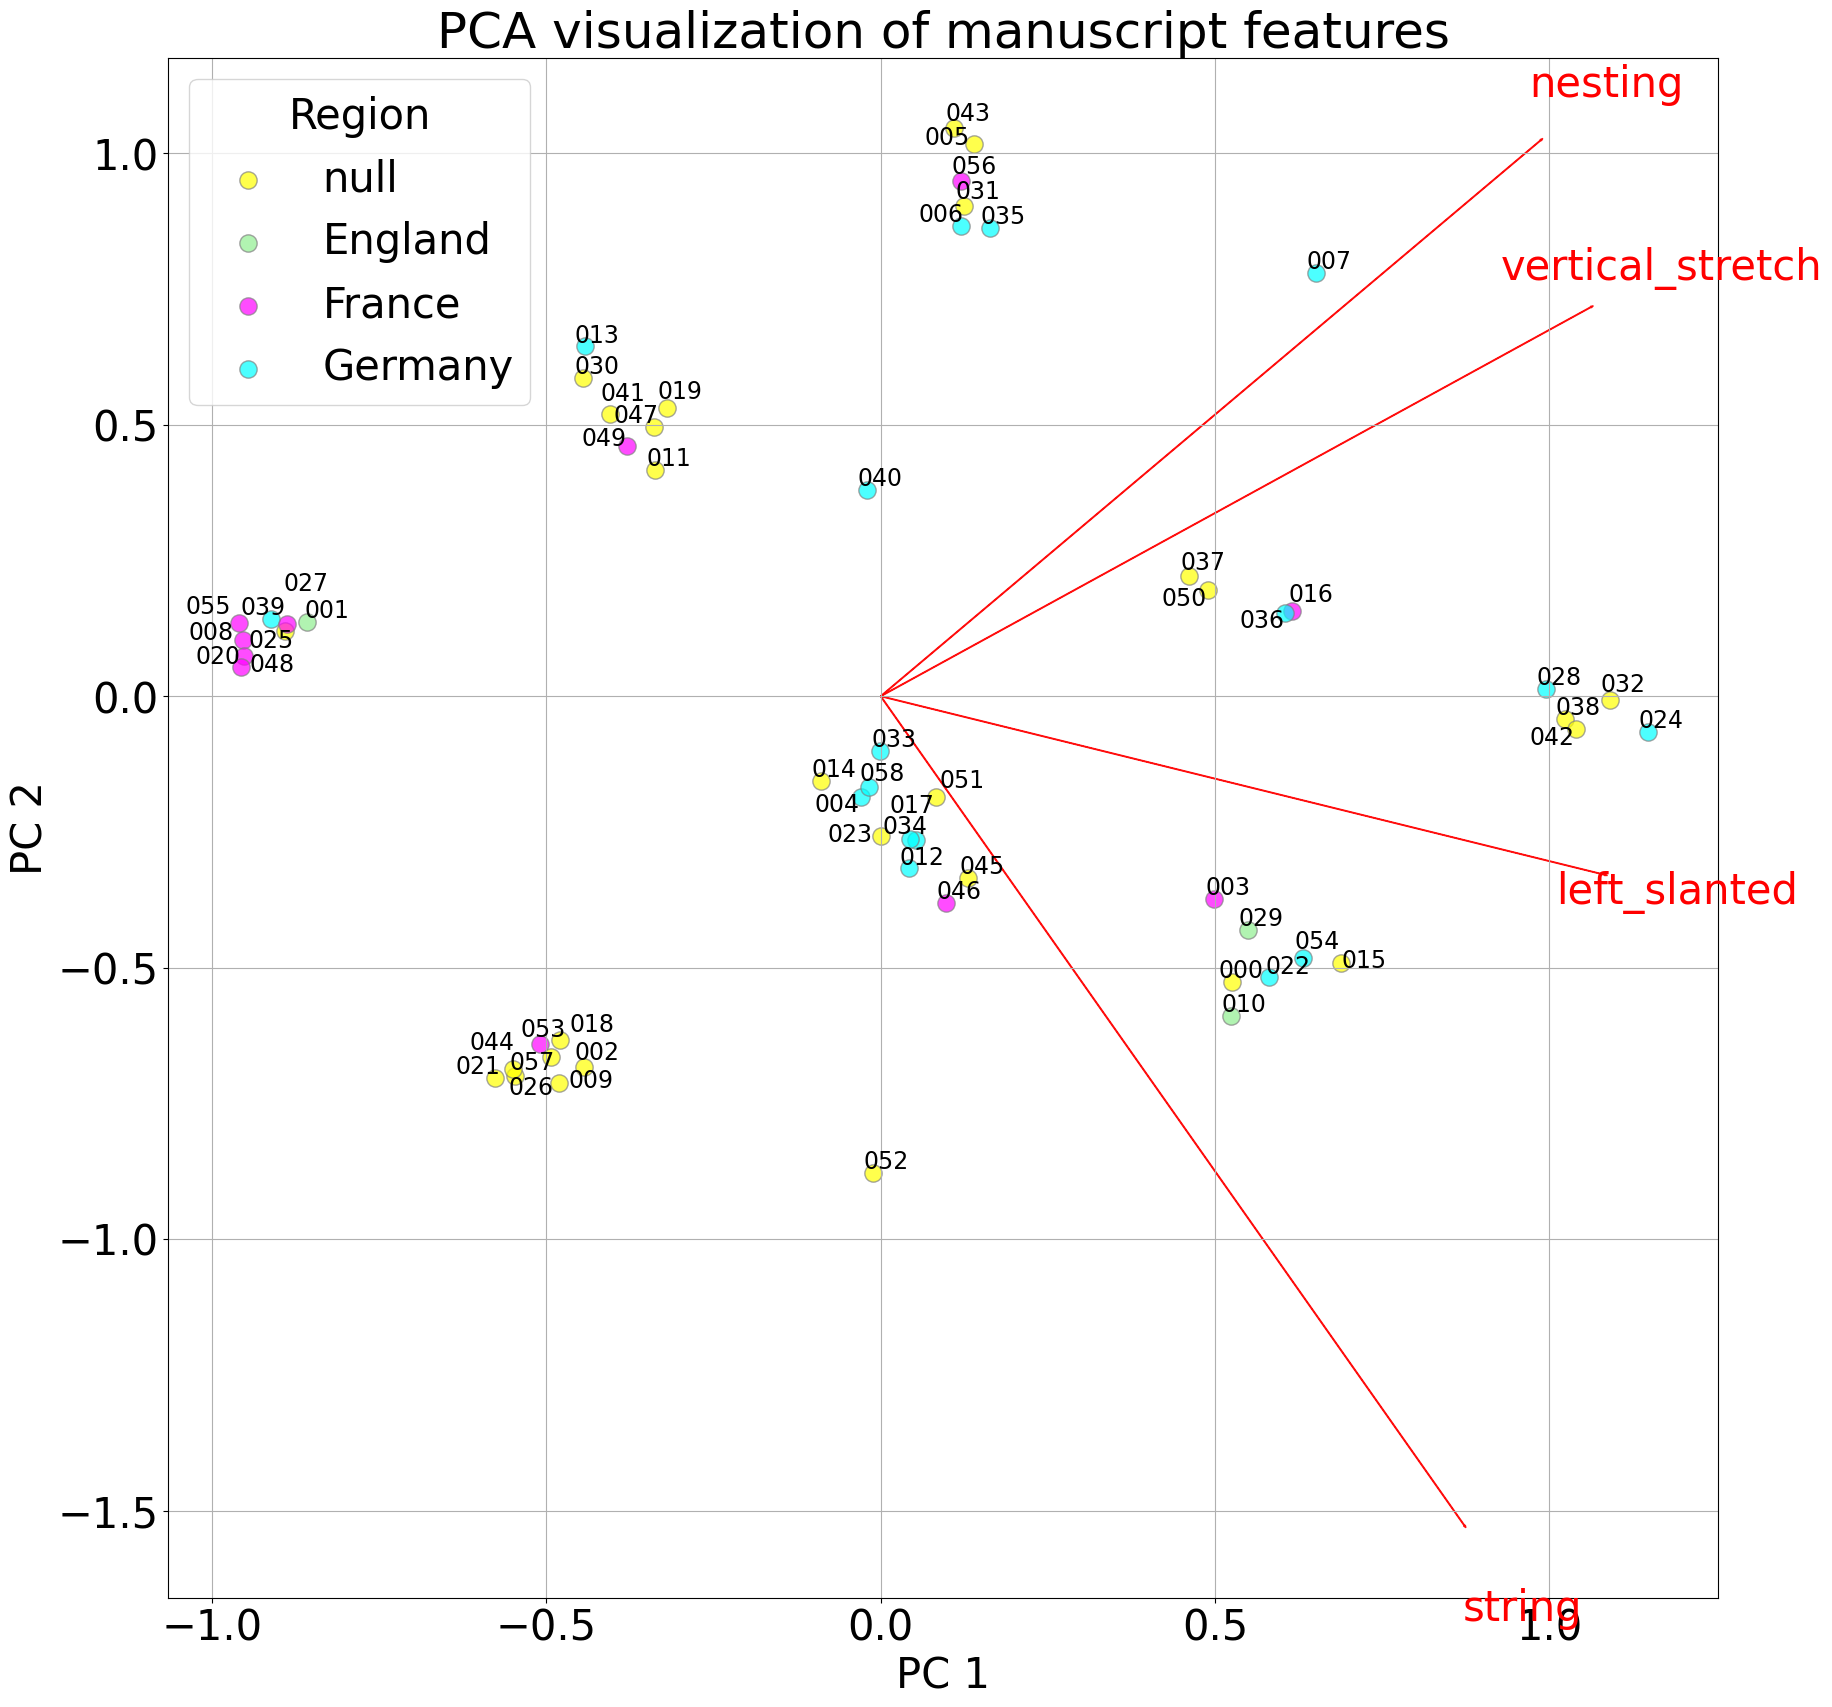

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from adjustText import adjust_text

# Prepare vectors and regions for PCA
indices_of_interest = [3, 4, 7, 8]  # Indices of tags of interest
filtered_vectors = np.array([manuscript_vectors[i][indices_of_interest] for i in range(len(manuscript_vectors))])
filtered_regions = manuscript_regions
filtered_dates = manuscript_dates
filtered_tags = [np.array(tags)[indices_of_interest][manuscript_vectors[i][indices_of_interest].astype(bool)].tolist() for i in range(len(manuscript_vectors))]

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(filtered_vectors)
loadings = pca.components_.T 

# Adding jitter
jitter_strength = 0.05
reduced_vectors[:, 0] += np.random.normal(0, jitter_strength, reduced_vectors.shape[0])
reduced_vectors[:, 1] += np.random.normal(0, jitter_strength, reduced_vectors.shape[0])

# Prepare vectors and regions for PCA
indices_of_interest = [3, 4, 7, 8]  # Indices of tags of interest
filtered_vectors = np.array([manuscript_vectors[i][indices_of_interest] for i in range(len(manuscript_vectors))])
filtered_regions = manuscript_regions
filtered_dates = manuscript_dates
filtered_tags = [np.array(tags)[indices_of_interest][manuscript_vectors[i][indices_of_interest].astype(bool)].tolist() for i in range(len(manuscript_vectors))]

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(filtered_vectors)
loadings = pca.components_.T 

# Adding jitter
jitter_strength = 0.05
reduced_vectors[:, 0] += np.random.normal(0, jitter_strength, reduced_vectors.shape[0])
reduced_vectors[:, 1] += np.random.normal(0, jitter_strength, reduced_vectors.shape[0])

# Plotting the results with jitter
colors = {
    "Germany": "cyan",
    "France": "magenta",
    "England": "lightgreen",
    "null": "yellow"
}
# Setup the plot as before
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20, 20))
texts = []  # List to store text objects for adjustment

for i, label in enumerate(filtered_regions):
    color = colors.get(label, 'gray')  # Default to gray if region not in dict
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], color=color, s=155, label=label if label not in plt.gca().get_legend_handles_labels()[1] else "", alpha=0.7, edgecolors='gray', linewidth=1)
    tag_text = f"{manuscript_names[i]}"
    text = plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], tag_text, fontsize=17, ha='right')
    texts.append(text)

# Adjusting text to minimize overlaps
adjust_text(texts)

# Plot the PCA loadings with jitter added
jitter_strength = 0.005
loadings[:, 0] += np.random.normal(0, jitter_strength, loadings.shape[0])
loadings[:, 1] += np.random.normal(0, jitter_strength, loadings.shape[0])
for i, (load1, load2) in enumerate(loadings):
    plt.arrow(0, 0, load1*2, load2*2, color='red', alpha=0.9)
    plt.text(load1*2.2, load2*2.2, tags[indices_of_interest[i]], color='red', ha='center', va='center')

plt.title('PCA visualization of manuscript features')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Region')
plt.grid(True)
plt.savefig("ASC_plot_with_4_tags.png", dpi=300)
plt.show()


In [1]:
import json
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Load the JSON file
with open('binary_multilabels.json', 'r') as file:
    data = json.load(file)

# Define the list of tags
tags = [
    "fish_tail", "shading", "short_descender", "string", "vertical_stretch",
    "nikud", "left_justify", "nesting", "left_slanted", "bited_aleph"
]

# Create a dictionary to store the tag vectors for each manuscript
manuscript_tags = {}

# Extract the images section which contains the tags
images = data['images']

# Initialize the tag vectors for each manuscript
for image in images:
    manuscript_name = image['image_name'].split('_')[0]
    if manuscript_name not in manuscript_tags:
        manuscript_tags[manuscript_name] = np.zeros(len(tags))
    
    # Set the corresponding tag positions to 1
    for tag in image['tags']:
        index = tags.index(tag)
        manuscript_tags[manuscript_name][index] = 1

# Convert to a list of vectors for further processing
manuscript_vectors = list(manuscript_tags.values())
manuscript_names = list(manuscript_tags.keys())


# Read the metadata file and extract dates and regions
metadata = {}
with open('mapping_sequentialnames_to_metadata_normaldate.txt', 'r') as file:
    for line in file:
        parts = line.strip().split('" "')
        sequential_name = parts[0].strip('"')
        manuscript_name = sequential_name.split('_')[0]
        date = parts[3].strip('"')
        region = parts[4].strip('"')
        
        if manuscript_name not in metadata:
            metadata[manuscript_name] = {"date": date, "region": region}

# Get dates and regions for each manuscript
manuscript_dates = [metadata.get(name, {}).get("date", 'Unknown') for name in manuscript_names]
manuscript_regions = [metadata.get(name, {}).get("region", 'Unknown') for name in manuscript_names]







In [9]:
manuscript_vectors_np = np.array(manuscript_vectors)
selected_dimensions_np = manuscript_vectors_np[:, [3, 4, 7, 8]]
selected_dimensions = selected_dimensions_np.tolist()


In [14]:
# Define the indices of the selected dimensions
selected_indices = [3, 4, 7, 8]

# Get the names of the tags for these selected indices
selected_tag_names = [tags[i] for i in selected_indices]

# Create selected_tags which contains the tag names if their corresponding value in the vector is 1
selected_tags = [
    [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
    for vector in selected_dimensions
]



In [17]:
# Define the cluster of manuscript names
cluster_manuscripts = ['002', '009', '018', '053', '057', '026', '044', '021']

# Filter the vectors and names to include only those in the cluster
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets
cluster_tags = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags = set.intersection(*cluster_tags) if cluster_tags else set()

# Convert the set of common tags to a list if needed
common_tags_list = list(common_tags)


In [18]:
common_tags_list

['string']

In [20]:
# Define the cluster of manuscript names
cluster_manuscripts = ['002', '009', '018', '053', '057', '026', '044', '021']

# Filter the vectors and names to include only those in the cluster
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag lists
cluster_tags = [
    [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
    for vector in cluster_vectors
]

# Count the occurrences of each tag in the cluster
tag_count = {tag: 0 for tag in selected_tag_names}
for tags in cluster_tags:
    for tag in tags:
        tag_count[tag] += 1

# Display the count of each tag
tag_count


{'string': 8, 'vertical_stretch': 0, 'nesting': 0, 'left_slanted': 0}

In [22]:
# Categorize manuscripts by region
region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute manuscripts into regions
for i, name in enumerate(manuscript_names):
    region = manuscript_regions[i]
    if region == 'Germany':
        region_manuscripts['Germany'].append(selected_dimensions[i])
    elif region == 'France':
        region_manuscripts['France'].append(selected_dimensions[i])
    else:
        region_manuscripts['Other'].append(selected_dimensions[i])

# Convert binary vectors to tag sets for each region and find common tags
common_tags_by_region = {}
for region, vectors in region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region = {region: list(tags) for region, tags in common_tags_by_region.items()}
common_tags_by_region


{'Germany': [], 'France': [], 'Other': []}

In [33]:
#cluster1
cluster_manuscripts = ['001', '027', '025', '048', '039', '008', '020', '055']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': [], 'France': [], 'Other': []}

In [37]:
#cluster1
cluster_manuscripts = ['001', '027', '025', '048', '039', '008', '020', '055']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


[]

In [45]:
# cluster1
cluster_manuscripts = ['001', '027', '025', '048', '039', '008', '020', '055']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [[]], 'France': [[], [], [], [], []], 'Other': [[], []]}

In [28]:
#cluster2
cluster_manuscripts = ['002', '009', '018', '053', '057', '026', '044', '021']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': [], 'France': ['string'], 'Other': ['string']}

In [38]:
#cluster2
cluster_manuscripts = ['002', '009', '018', '053', '057', '026', '044', '021']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


['string']

In [46]:
#cluster2
cluster_manuscripts = ['002', '009', '018', '053', '057', '026', '044', '021']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [],
 'France': [['string']],
 'Other': [['string'],
  ['string'],
  ['string'],
  ['string'],
  ['string'],
  ['string'],
  ['string']]}

In [30]:
#cluster3
cluster_manuscripts = ['033', '058', '014', '051', '004', '034', '023', '012', '045', '046', '017']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': ['string'],
 'France': ['string', 'vertical_stretch'],
 'Other': ['string']}

In [39]:
#cluster3
cluster_manuscripts = ['033', '058', '014', '051', '004', '034', '023', '012', '045', '046', '017']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


['string']

In [47]:
#cluster3
cluster_manuscripts = ['033', '058', '014', '051', '004', '034', '023', '012', '045', '046', '017']


# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [['string', 'nesting'],
  ['string', 'vertical_stretch'],
  ['string', 'vertical_stretch'],
  ['string', 'nesting'],
  ['string', 'vertical_stretch'],
  ['string', 'nesting']],
 'France': [['string', 'vertical_stretch']],
 'Other': [['string', 'nesting'],
  ['string', 'vertical_stretch'],
  ['string', 'vertical_stretch'],
  ['string', 'nesting']]}

In [31]:
#cluster4
cluster_manuscripts = ['003', '029', '054', '015', '022', '002', '010']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': ['string', 'vertical_stretch', 'left_slanted'],
 'France': ['string', 'nesting', 'left_slanted'],
 'Other': ['string']}

In [40]:
#cluster4
cluster_manuscripts = ['003', '029', '054', '015', '022', '002', '010']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


['string']

In [48]:
#cluster4
cluster_manuscripts = ['003', '029', '054', '015', '022', '002', '010']


# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [['string', 'vertical_stretch', 'left_slanted'],
  ['string', 'vertical_stretch', 'left_slanted']],
 'France': [['string', 'nesting', 'left_slanted']],
 'Other': [['string'],
  ['string', 'vertical_stretch', 'left_slanted'],
  ['string', 'vertical_stretch', 'left_slanted'],
  ['string', 'nesting', 'left_slanted']]}

In [32]:
#cluster5
cluster_manuscripts = ['028', '032', '038', '042', '024']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': ['string', 'vertical_stretch', 'nesting', 'left_slanted'],
 'France': [],
 'Other': ['string', 'vertical_stretch', 'nesting', 'left_slanted']}

In [41]:
#cluster5
cluster_manuscripts = ['028', '032', '038', '042', '024']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


['string', 'vertical_stretch', 'nesting', 'left_slanted']

In [52]:
#cluster5
cluster_manuscripts = ['028', '032', '038', '042', '024']


# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [['string', 'vertical_stretch', 'nesting', 'left_slanted'],
  ['string', 'vertical_stretch', 'nesting', 'left_slanted']],
 'France': [],
 'Other': [['string', 'vertical_stretch', 'nesting', 'left_slanted'],
  ['string', 'vertical_stretch', 'nesting', 'left_slanted'],
  ['string', 'vertical_stretch', 'nesting', 'left_slanted']]}

In [34]:
#cluster6
cluster_manuscripts = ['037', '050', '016', '036']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': ['string', 'nesting', 'vertical_stretch'],
 'France': ['string', 'nesting', 'vertical_stretch'],
 'Other': ['string', 'vertical_stretch', 'nesting']}

In [53]:
#cluster6
cluster_manuscripts = ['037', '050', '016', '036']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


['string', 'vertical_stretch', 'nesting']

In [49]:
#cluster6
cluster_manuscripts = ['037', '050', '016', '036']


# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [['string', 'vertical_stretch', 'nesting']],
 'France': [['string', 'vertical_stretch', 'nesting']],
 'Other': [['string', 'vertical_stretch', 'nesting'],
  ['string', 'vertical_stretch', 'nesting']]}

In [35]:
#cluster7
cluster_manuscripts = ['043', '005', '056', '031', '035', '006']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': ['vertical_stretch', 'nesting'],
 'France': ['nesting', 'vertical_stretch'],
 'Other': ['vertical_stretch', 'nesting']}

In [43]:
#cluster7
cluster_manuscripts = ['043', '005', '056', '031', '035', '006']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


['vertical_stretch', 'nesting']

In [50]:
#cluster7
cluster_manuscripts = ['043', '005', '056', '031', '035', '006']


# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [['vertical_stretch', 'nesting'], ['vertical_stretch', 'nesting']],
 'France': [['vertical_stretch', 'nesting']],
 'Other': [['vertical_stretch', 'nesting'],
  ['vertical_stretch', 'nesting'],
  ['vertical_stretch', 'nesting']]}

In [36]:
#cluster8
cluster_manuscripts = ['013', '030', '041', '047', '019', '011','049']

# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag sets for each region in the cluster and find common tags
common_tags_by_region_in_cluster = {}
for region, vectors in cluster_region_manuscripts.items():
    tag_sets = [
        {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
        for vector in vectors
    ]
    common_tags_by_region_in_cluster[region] = set.intersection(*tag_sets) if tag_sets else set()

# Convert the set of common tags to a list if needed and display the results
common_tags_by_region_in_cluster = {region: list(tags) for region, tags in common_tags_by_region_in_cluster.items()}
common_tags_by_region_in_cluster


{'Germany': ['nesting'], 'France': ['vertical_stretch'], 'Other': []}

In [44]:
#cluster8
cluster_manuscripts = ['013', '030', '041', '047', '019', '011','049']

# Extract vectors for the cluster manuscripts
cluster_vectors = [selected_dimensions[i] for i, name in enumerate(manuscript_names) if name in cluster_manuscripts]

# Convert binary vectors to tag sets for the cluster
cluster_tag_sets = [
    {selected_tag_names[i] for i, value in enumerate(vector) if value == 1}
    for vector in cluster_vectors
]

# Find the intersection of all tag sets to identify common tags
common_tags_in_cluster = set.intersection(*cluster_tag_sets) if cluster_tag_sets else set()

# Convert the set of common tags to a list if needed
common_tags_in_cluster = list(common_tags_in_cluster)
common_tags_in_cluster


[]

In [51]:
#cluster8
cluster_manuscripts = ['013', '030', '041', '047', '019', '011','049']


# Categorize manuscripts in the cluster by region
cluster_region_manuscripts = {
    'Germany': [],
    'France': [],
    'Other': []
}

# Distribute cluster manuscripts into regions
for i, name in enumerate(manuscript_names):
    if name in cluster_manuscripts:
        region = manuscript_regions[i]
        vector = selected_dimensions[i]
        if region == 'Germany':
            cluster_region_manuscripts['Germany'].append(vector)
        elif region == 'France':
            cluster_region_manuscripts['France'].append(vector)
        else:
            cluster_region_manuscripts['Other'].append(vector)

# Convert binary vectors to tag lists for each region
tags_by_region = {}
for region, vectors in cluster_region_manuscripts.items():
    region_tags = [
        [selected_tag_names[i] for i, value in enumerate(vector) if value == 1]
        for vector in vectors
    ]
    tags_by_region[region] = region_tags

# Display the tags by region
tags_by_region


{'Germany': [['nesting']],
 'France': [['vertical_stretch']],
 'Other': [['vertical_stretch'],
  ['vertical_stretch'],
  ['nesting'],
  ['vertical_stretch'],
  ['vertical_stretch']]}